In [1]:
import pandas as pd
# coding: UTF-8
import time
import torch
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from torch.utils.data import SubsetRandomSampler
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from units import *

### 数据预处理

In [2]:
rawdata=pd.read_excel("../backup/arousal_record.xlsx")
rawdata=rawdata[['aweme_id','collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
rawdata=rawdata[rawdata['variation'].notna()]
rawdata=rawdata[rawdata['arousal'].notna()]
def keyword_encode(keyword):
    if "运动" in keyword:
        return 0
    elif "健身" in keyword:
        return 1
    elif "减肥" in keyword:
        return 2
    elif "自律" in keyword:
        return 3
rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
rawdata.fillna(0) # 空值填充0
rawdata['intention_counts']=rawdata['intention_counts']/rawdata['comment_get']
rawdata.drop('comment_get',axis=1)
columns=['aweme_id','collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation', 'arousal' ,'V*A','digg_count', 'intention_counts']
rawdata['V*A']=rawdata['variation']*rawdata['arousal']
rawdata=rawdata[columns]
rawdata

,aweme_id,collect_count,create_time,duration,follower_count,gender,share_count,keyword,comment_count,variation,arousal,V*A,digg_count,intention_counts
0,6804790633828584719,824,1584363784,36987,1030322,2.0,1467,0,1377,0.089440,-0.819733,-0.073317,29483,0.179487
1,7124609770450898208,922,1658827484,47970,191416,1.0,737,0,702,0.206536,-0.277983,-0.057413,17382,0.150000
2,6951683898308824324,2258,1618565043,59278,1656398,2.0,1666,0,528,0.099483,-0.001633,-0.000162,26911,0.051282
3,7070127078942821643,83,1646142240,28651,311073,2.0,124,0,36,0.206139,-0.896651,-0.184835,1872,0.500000
4,7074121926976736547,715,1647072363,41608,120088,2.0,788,0,405,0.277655,-0.815455,-0.226415,7831,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940,7179756963759230268,16,1671667447,170921,7801,0.0,16,1,100,0.250311,0.213098,0.053341,400,0.210526
3941,7187301703543246113,35,1673424099,10564,27519,0.0,42,1,38,0.133576,-0.912319,-0.121864,474,0.125000
3942,7144163419665583401,15,1663380177,289320,7801,0.0,25,1,98,0.227938,-0.207814,-0.047369,401,0.200000
3943,7177306735663713597,2,1671096956,26367,807,0.0,164,1,81,0.208135,-0.371636,-0.077350,399,0.074074


In [3]:
select_num=220
select_pd=pd.DataFrame()
select_pd=select_pd.append(rawdata.sort_values(by=['variation','arousal'],ascending=[False,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['arousal','variation'],ascending=[False,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['variation','arousal'],ascending=[True,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['arousal','variation'],ascending=[True,False]).head(select_num),ignore_index=True)
rawdata=select_pd.drop_duplicates('aweme_id')

### 数据归一化

In [4]:
scaler = MinMaxScaler() #实例化
rawdata = scaler.fit_transform(rawdata) #fit，在这里本质是生成min(x)和max(x)
rawdata = pd.DataFrame(rawdata,columns=columns)
rawdata.fillna(0)

,aweme_id,collect_count,create_time,duration,follower_count,gender,share_count,keyword,comment_count,variation,arousal,V*A,digg_count,intention_counts
0,0.974564,0.016279,0.974557,0.019809,0.637966,0.0,0.014372,0.000000,0.059934,1.000000,0.319643,0.620008,0.026852,0.140679
1,0.308107,0.002514,0.307920,0.142441,0.094531,1.0,0.002560,1.000000,0.068854,0.695471,0.122361,0.029631,0.060070,0.025641
2,0.551904,0.000623,0.551783,0.021538,0.011217,0.5,0.000343,1.000000,0.007975,0.680344,0.107868,0.000000,0.010111,0.179487
3,0.985085,0.004906,0.985090,0.263080,0.066813,1.0,0.001775,0.666667,0.014153,0.525950,0.462579,1.000000,0.007999,0.001350
4,0.059985,0.000206,0.059978,0.046876,0.099265,0.5,0.000753,0.000000,0.010979,0.471385,0.050238,0.094614,0.015191,0.128205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,0.377014,0.000123,0.376846,0.000696,0.006538,1.0,0.000041,1.000000,0.002105,0.037228,0.043761,0.656487,0.001424,0.179487
809,0.827713,0.000031,0.827666,0.010393,0.003807,0.0,0.000009,0.333333,0.000683,0.034346,0.043809,0.660316,0.000135,0.076923
810,0.781586,0.003645,0.782117,0.070414,0.244143,1.0,0.007051,0.666667,0.040753,0.040498,0.044040,0.652205,0.066788,0.051282
811,0.796281,0.000244,0.796226,0.127266,0.181805,0.5,0.001026,0.666667,0.006007,0.029541,0.044242,0.666746,0.001528,0.153846


### 划分数据集

In [5]:
# r2_lst=[]
# for i in range(100):
#     X_train, X_test, y_train, y_test = train_test_split(rawdata.iloc[:,:-2], rawdata.iloc[:,-1], test_size=0.10,random_state=i)
#     from sklearn.model_selection import cross_val_score
#     model = XGBRegressor()
#     model.fit(X_train,y_train)
#     scores = model.score(X_test,y_test)
#     r2_lst.append(scores)
#     print(scores)                                          
X_train, X_test, y_train, y_test = train_test_split(rawdata.iloc[:,:-2], rawdata.iloc[:,-1], test_size=0.20,random_state=12)
model = XGBRegressor()
model.fit(X_train,y_train)
scores = model.score(X_test,y_test)
print(scores)           
y_pred=model.predict(X_test)                              

-0.08560179816128666


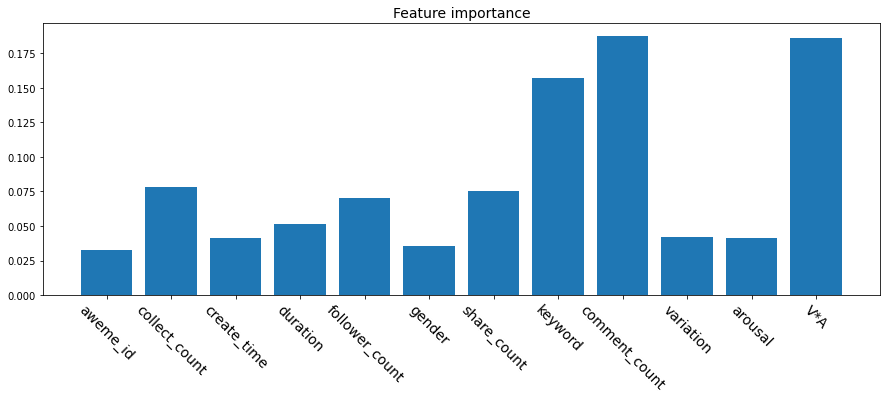

In [7]:
# 获取feature importance
import matplotlib.pyplot as plt
cols=rawdata.iloc[:,:-2].columns
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

In [8]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(rawdata.iloc[:,:-2][cols])

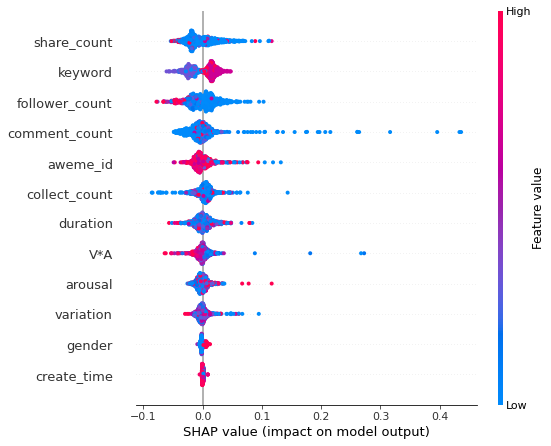

In [9]:
shap.summary_plot(shap_values, rawdata.iloc[:,:-2][cols])

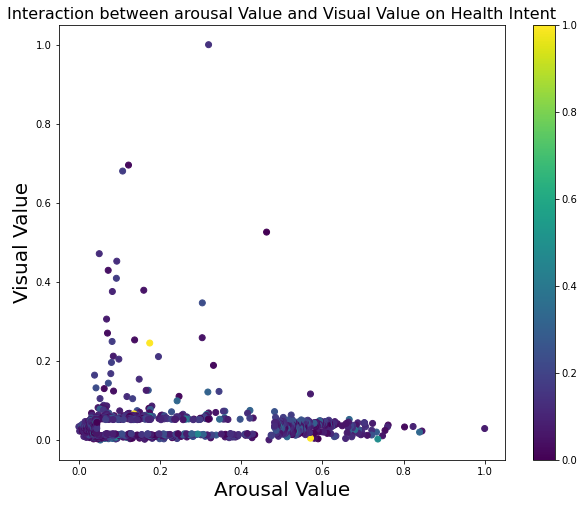

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
# 绘制散点图
plt.scatter(rawdata['arousal'], rawdata['variation'], c=rawdata['intention_counts'])
# 添加图例
plt.colorbar()
# 添加坐标轴标签
plt.xlabel("Arousal Value",size=20)
plt.ylabel("Visual Value",size=20)
# 添加标题
plt.title("Interaction between arousal Value and Visual Value on Health Intent",size=16)
# 显示图像
plt.show()

### 分类

In [36]:
rawdata=pd.read_excel("../backup/arousal_record.xlsx")
rawdata=rawdata[['collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
rawdata=rawdata[rawdata['variation'].notna()]
rawdata=rawdata[rawdata['arousal'].notna()]
def keyword_encode(keyword):
    if "运动" in keyword:
        return 0
    elif "健身" in keyword:
        return 1
    elif "减肥" in keyword:
        return 2
    elif "自律" in keyword:
        return 3
rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
rawdata.fillna(0) # 空值填充0
rawdata.drop('comment_get',axis=1)
columns=['collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation', 'arousal' ,'digg_count', 'intention_counts']
rawdata=rawdata[columns]
rawdata=rawdata.replace('NA',0)
rawdata['intention_counts'][rawdata['intention_counts']==1]=0
rawdata['intention_counts'][rawdata['intention_counts']>1]=1
rawdata=rawdata.dropna()
x=rawdata.iloc[:,:-1]
y=rawdata.iloc[:,-1]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
scaler = MinMaxScaler() #实例化
x = scaler.fit_transform(x) #fit，在这里本质是生成min(x)和max(x)
x = pd.DataFrame(x)

In [38]:
y.value_counts()

1    3120
0     546
Name: intention_counts, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20)
dataset=X_train, y_train, X_test, y_test

BaseLine : XGBoost
Running time: 0.37996912002563477 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.55,0.88,0.85,0.72,0.83
recall,0.28,0.96,0.85,0.62,0.85
f1-score,0.37,0.92,0.85,0.64,0.83
support,114.00,620.00,0.85,734.00,734.00


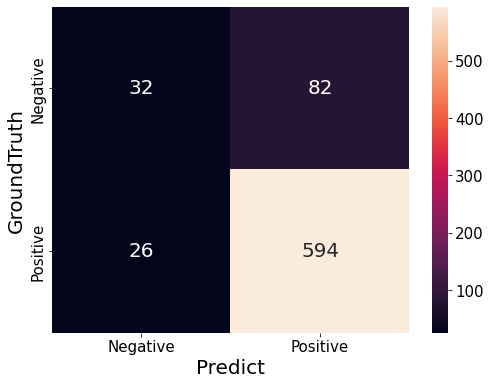

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,XGBoost,0.852861,0.878698,0.320578,0.878698,0.551724,0.958065,0.916667,0.38,594,82,32,26


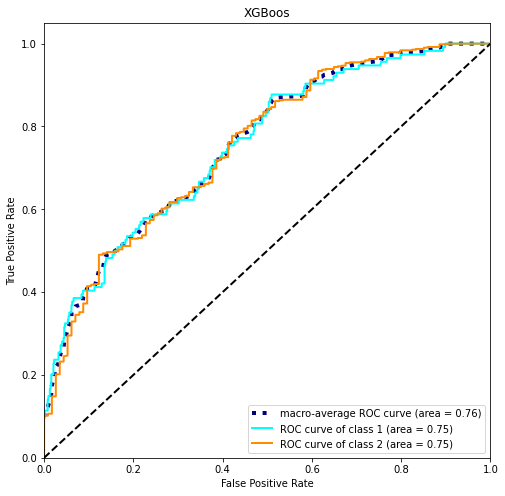

BaseLine : NaiveBayes
Running time: 0.012324333190917969 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.21,0.91,0.52,0.56,0.80
recall,0.75,0.48,0.52,0.61,0.52
f1-score,0.33,0.63,0.52,0.48,0.58
support,114.00,620.00,0.52,734.00,734.00


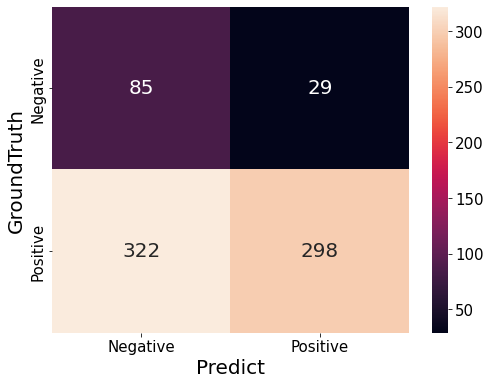

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,NaiveBayes,0.521798,0.911315,0.164886,0.911315,0.208845,0.480645,0.629356,0.01,298,29,85,322


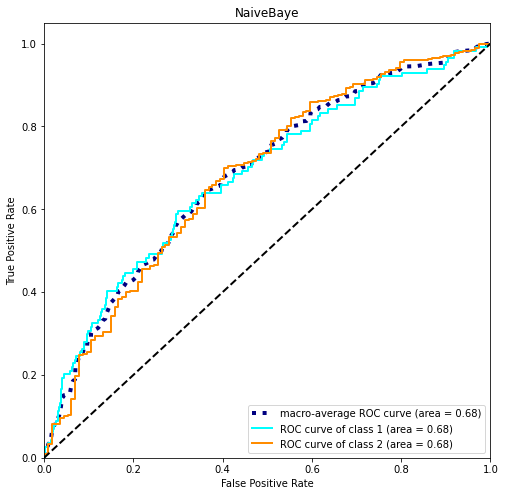

BaseLine : GradientBoosting
Running time: 0.7993876934051514 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.62,0.88,0.86,0.75,0.84
recall,0.27,0.97,0.86,0.62,0.86
f1-score,0.38,0.92,0.86,0.65,0.84
support,114.00,620.00,0.86,734.00,734.00


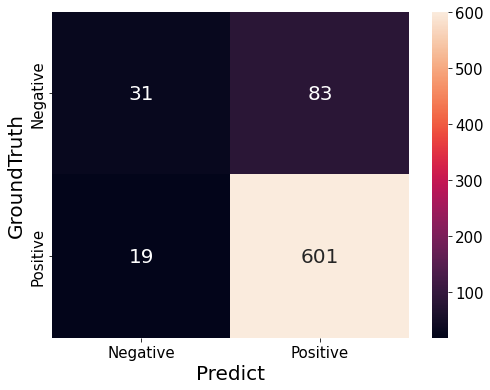

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,GradientBoosting,0.861035,0.878655,0.346869,0.878655,0.62,0.969355,0.921779,0.8,601,83,31,19


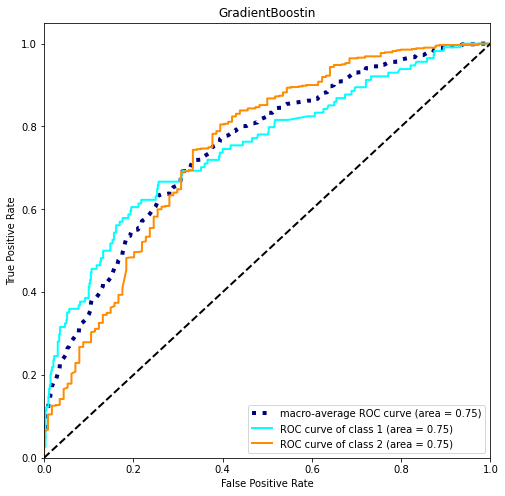

In [40]:
methods=['XGBoost','NaiveBayes','GradientBoosting']
method_compare=[]
label_column=['Positive','Negative']
for method in methods:
    path='save/'+method+'/'
    if not os.path.isdir(path):
        os.makedirs(path)
    print('='*100)
    print('BaseLine : '+method)
    groundtruth, predict, predictprob,item=evaluate(method,dataset)
    method_compare.append(item)
    # 导出报告
    matrix=metrics.confusion_matrix(groundtruth, predict)
    result=pd.DataFrame(matrix,columns=label_column,index=label_column)
    report=classification_report(groundtruth, predict,target_names=label_column,output_dict=True)
    report=round(pd.DataFrame(report).T,2)
    report.T.to_csv(path+'report.csv',encoding='utf_8')
    display(report.T)
    plot_matrix(groundtruth, predict,path+'./confusion_matrix.png')
    display(pd.DataFrame([method_compare[-1]]))
    ROC_plot(y_test,predictprob,path+method)

### 机器模型比对

In [41]:
pd.DataFrame(method_compare)

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,XGBoost,0.852861,0.878698,0.320578,0.878698,0.551724,0.958065,0.916667,0.38,594,82,32,26
1,NaiveBayes,0.521798,0.911315,0.164886,0.911315,0.208845,0.480645,0.629356,0.01,298,29,85,322
2,GradientBoosting,0.861035,0.878655,0.346869,0.878655,0.620000,0.969355,0.921779,0.80,601,83,31,19
